# TQuant Lab SuperTrend Strategy

In [1]:
import os
import numpy as np
import pandas as pd

# tej_key
tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start = '2018-12-28', 
                    end = '2018-12-28',
                    mkt_bd_e = 'TSE',  # Listed stock in Taiwan
                    stktp_e = 'Common Stock', 
                    main_ind_c = 'M2300 電子工業'  # Electronics Industry
                    )

Currently used TEJ API key call quota 3254/100000 (3.25%)
Currently used TEJ API key data quota 303006/10000000 (3.03%)


In [3]:
len(pool)

387

In [4]:
import TejToolAPI

mktcap_data = TejToolAPI.get_history_data(start = '2018-12-28',
                                          end = '2018-12-28',
                                          ticker = pool,
                                          columns = ['Market_Cap_Dollars']
                                         )

mktcap_data

Currently used TEJ API key call quota 3275/100000 (3.27%)
Currently used TEJ API key data quota 367800/10000000 (3.68%)


,coid,mdate,Market_Cap_Dollars
0,1471,2018-12-28,7.731310e+08
1,1582,2018-12-28,7.930719e+09
2,2059,2018-12-28,3.049506e+10
3,2301,2018-12-28,9.544520e+10
4,2302,2018-12-28,1.242283e+09
...,...,...,...
382,8215,2018-12-28,5.355264e+09
383,8249,2018-12-28,2.528395e+09
384,8261,2018-12-28,2.517488e+09
385,8271,2018-12-28,2.875587e+09


In [5]:
tickers = mktcap_data.nlargest(10, 'Market_Cap_Dollars')['coid'].tolist()
tickers

['2330',
 '2317',
 '2412',
 '3008',
 '2454',
 '3045',
 '2308',
 '3711',
 '4904',
 '2382']

In [6]:
start = '2019-01-01'
end = '2024-07-01'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant

[2024-08-15 07:55:36.929016] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-08-15 07:55:42.248090] INFO: zipline.data.bundles.core: Ingest tquant successfully.


Merging daily equity files:
Currently used TEJ API key call quota 3284/100000 (3.28%)
Currently used TEJ API key data quota 418146/10000000 (4.18%)


In [7]:
from zipline.pipeline import CustomFactor
from zipline.pipeline.data import TWEquityPricing

class Supertrend(CustomFactor):
    inputs = [
        TWEquityPricing.high,
        TWEquityPricing.low,
        TWEquityPricing.close,
    ]
    window_length = 50  # Use a 50-day window length
    outputs = ['atr', 'basic_upperband', 'basic_lowerband', 'final_upperband', 'final_lowerband']

    def compute(self, today, assets, out, highs, lows, closes):
        # Calculate TR (True Range)
        high_low = highs[1:] - lows[1:]
        high_close = abs(highs[1:] - closes[:-1])
        low_close = abs(lows[1:] - closes[:-1])
        tr = np.maximum.reduce([high_low, high_close, low_close])

        # Calculate ATR (Average True Range)
        atr = np.mean(tr, axis=0)
        out.atr = atr

        # Calculate basic upperband & lowerband
        hl2 = (highs + lows) / 2
        basic_upperband = hl2 + 4 * atr
        basic_lowerband = hl2 - 4 * atr

        # Initialize final upperband & lowerband
        final_upperband = np.zeros_like(basic_upperband)
        final_lowerband = np.zeros_like(basic_lowerband)

        # Calculate fianl upperband & lowerband
        for i in range(1, len(closes)):
            final_upperband[i] = np.where(
                (basic_upperband[i] < final_upperband[i-1]) | (closes[i-1] > final_upperband[i-1]),
                basic_upperband[i],
                final_upperband[i-1]
            )
            
            final_lowerband[i] = np.where(
                (basic_lowerband[i] > final_lowerband[i-1]) | (closes[i-1] < final_lowerband[i-1]),
                basic_lowerband[i],
                final_lowerband[i-1]
            )
            
        out.basic_upperband = basic_upperband[-1]
        out.basic_lowerband = basic_lowerband[-1]
        out.final_upperband = final_upperband[-1]
        out.final_lowerband = final_lowerband[-1]

In [8]:
class ADX(CustomFactor):
    inputs = [TWEquityPricing.high, TWEquityPricing.low, TWEquityPricing.close]
    window_length = 14  # ADX通常使用14天作為默認週期
    outputs = ['adx']
    
    def compute(self, today, assets, out, highs, lows, closes):
        # Calculate TR (True Range)
        high_low = highs[1:] - lows[1:]
        high_close = abs(highs[1:] - closes[:-1])
        low_close = abs(lows[1:] - closes[:-1])
        tr = np.maximum.reduce([high_low, high_close, low_close])

        # Calculate ATR (Average True Range)
        atr = np.mean(tr, axis=0)
        
        # Calculate +DM, -DM (Directional Movement)
        up_move = highs[1:] - lows[:-1]
        down_move = lows[:-1] - lows[1:]
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
        
        # Calaulate rolling mean of +DM & -DM (smoothing)
        plus_dm_smooth = np.mean(plus_dm, axis=0)
        minus_dm_smooth = np.mean(minus_dm, axis=0)
        
        # Calculate +DI, -DI (Directional Indicator)
        di_plus = 100 * np.divide(plus_dm_smooth, atr)
        di_minus = 100 * np.divide(minus_dm_smooth, atr)
        
        # Calculate DX
        dx = 100 * np.divide(np.abs(di_plus - di_minus), np.abs(di_plus + di_minus))
        
        # Calculate ADX (rolling mean of DX)
        dx_series = pd.DataFrame(dx)
        adx = dx_series.rolling(window = 50, min_periods = 1).mean().values.flatten()

        out.adx = adx

In [9]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets

bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():

    close = TWEquityPricing.close.latest
    supertrend = Supertrend()
    adx = ADX()
    
    return Pipeline(
        columns={
            'close': close,
            'final_upperband': supertrend.final_upperband,
            'final_lowerband': supertrend.final_lowerband,
            'ADX': adx.adx
        },
        screen = ~StaticAssets([benchmark_asset])
    )

pipeline_result = run_pipeline(make_pipeline(), start, end)
pipeline_result 

close  final_upperband  \
2019-01-03 00:00:00+00:00 Equity(0 [2308])   127.000000         0.000000   
                          Equity(1 [2317])    70.100000         0.000000   
                          Equity(2 [2330])   219.500000         0.000000   
                          Equity(3 [2382])    52.100000         0.000000   
                          Equity(4 [2412])   107.000000         0.000000   
...                                                 ...              ...   
2024-07-01 00:00:00+00:00 Equity(5 [2454])  1400.000000      1547.867347   
                          Equity(6 [3008])  2745.000000      2849.540816   
                          Equity(7 [3045])   107.000000       110.846939   
                          Equity(8 [3711])   163.297717       179.041069   
                          Equity(9 [4904])    84.100000        88.675510   

                                            final_lowerband        ADX  
2019-01-03 00:00:00+00:00 Equity(0 [2308])         0.000000        NaN  
                          Equity(1 [2317])         0.000000        NaN  
                          Equity(2 [2330])         0.000000        NaN  
                          Equity(3 [2382])         0.000000        NaN  
                          Equity(4 [2412])         0.000000        NaN  
...                                                     ...        ...  
2024-07-01 00:00:00+00:00 Equity(5 [2454])      1309.632653  82.046172  
                          Equity(6 [3008])      2497.959184  82.670969  
                          Equity(7 [3045])       101.903061  83.112960  
                          Equity(8 [3711])       155.307373  81.682419  
                          Equity(9 [4904])        80.874490  81.133225  

[13330 rows x 4 columns]

In [10]:
from zipline.finance import slippage, commission
from zipline.utils.calendar_utils import get_calendar
from logbook import Logger, StderrHandler, INFO
from zipline.api import *

# Set up 'log' so we can see trading details when backtesting.
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.Custom_TW_Commission())
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.has_ordered = {}

In [11]:
def handle_data(context, data):
        
    out_dir = pipeline_output('mystrategy')

    for i in out_dir.index: 
        sym = i.symbol
        price = out_dir.loc[i, 'close']
        ADX = out_dir.loc[i, 'ADX']
        final_upperband = out_dir.loc[i, 'final_upperband']
        final_lowerband = out_dir.loc[i, 'final_lowerband']
        
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount

        buy, sell = False, False

        if context.has_ordered.get(f'{i}') is None:
            context.has_ordered[f'{i}'] = False
        
        record(
           **{
                f'price_{sym}': price,
                f'buy_{sym}': buy,
                f'sell_{sym}': sell 
            }
        )

        if stock_position == 0:
            if (context.has_ordered[f'{i}'] == False) and (price > final_upperband):
                order_target_percent(i, 1/len(tickers))
                buy = True
                context.has_ordered[f'{i}'] = True
                record(**{f'buy_{sym}': buy})

        elif stock_position > 0:
            if (context.has_ordered[f'{i}'] == True) and (price < final_lowerband) and (ADX > 50):
                order_target_percent(i, 0)
                sell = True
                context.has_ordered[f'{i}'] = False
                record(**{f'sell_{sym}': sell})

In [12]:
def analyze(context, perf):
    pass

In [13]:
start_dt = pd.Timestamp(start, tz = 'utc')
end_dt = pd.Timestamp(end, tz = 'UTC')

from zipline import run_algorithm
results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 1e7,
    handle_data = handle_data
)

[2024-08-15 07:55:50.612832]: INFO: earn_dividends: Equity(2 [2330]), cash_dividend amount: 8.0, pay_date: 2019-07-18, div_owed: 37120.0
[2024-08-15 07:55:50.680265]: INFO: earn_dividends: Equity(0 [2308]), cash_dividend amount: 5.0, pay_date: 2019-07-26, div_owed: 37970.0
[2024-08-15 07:55:50.730808]: INFO: earn_dividends: Equity(5 [2454]), cash_dividend amount: 9.0, pay_date: 2019-08-01, div_owed: 40266.0
[2024-08-15 07:55:50.744792]: INFO: earn_dividends: Equity(7 [3045]), cash_dividend amount: 5.54897, pay_date: 2019-07-31, div_owed: 52099.27933
[2024-08-15 07:55:50.885235]: INFO: earn_dividends: Equity(1 [2317]), cash_dividend amount: 4.0, pay_date: 2019-08-23, div_owed: 61376.0
[2024-08-15 07:55:50.887248]: INFO: earn_dividends: Equity(4 [2412]), cash_dividend amount: 4.479, pay_date: 2019-08-28, div_owed: 41856.255
[2024-08-15 07:55:51.341783]: INFO: earn_dividends: Equity(3 [2382]), cash_dividend amount: 3.55, pay_date: 2019-08-23, div_owed: 67616.84999999999
[2024-08-15 07:55:

In [14]:
results

,period_open,period_close,net_leverage,orders,long_exposure,positions,benchmark_return,short_value,treasury_return,starting_cash,...,sell_3008,price_3045,buy_3045,sell_3045,price_3711,buy_3711,sell_3711,price_4904,buy_4904,sell_4904
2019-01-02 13:30:00+08:00,2019-01-02 09:01:00+08:00,2019-01-02 13:30:00+08:00,0.000000,[],0.0,[],NaN,0.0,0.0,1.000000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03 13:30:00+08:00,2019-01-03 09:01:00+08:00,2019-01-03 13:30:00+08:00,0.000000,"[{'id': '2bdff06e7a084841bdf76b5b9e67fc2f', 'd...",0.0,[],-0.006460,0.0,0.0,1.000000e+07,...,False,107.0,True,False,56.500000,True,False,72.4,True,False
2019-01-04 13:30:00+08:00,2019-01-04 09:01:00+08:00,2019-01-04 13:30:00+08:00,0.987791,"[{'id': '2bdff06e7a084841bdf76b5b9e67fc2f', 'd...",9864006.5,"[{'sid': Equity(0 [2308]), 'amount': 7692, 'co...",-0.011579,0.0,0.0,1.000000e+07,...,False,106.5,False,False,56.000000,False,False,72.3,False,False
2019-01-07 13:30:00+08:00,2019-01-07 09:01:00+08:00,2019-01-07 13:30:00+08:00,0.988055,[],10084742.1,"[{'sid': Equity(0 [2308]), 'amount': 7692, 'co...",0.022146,0.0,0.0,1.219202e+05,...,False,106.5,False,False,55.200000,False,False,72.3,False,False
2019-01-08 13:30:00+08:00,2019-01-08 09:01:00+08:00,2019-01-08 13:30:00+08:00,0.988070,[],10098102.4,"[{'sid': Equity(0 [2308]), 'amount': 7692, 'co...",-0.002784,0.0,0.0,1.219202e+05,...,False,108.0,False,False,55.000000,False,False,73.7,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-25 13:30:00+08:00,2024-06-25 09:01:00+08:00,2024-06-25 13:30:00+08:00,1.034144,[],34606662.2,"[{'sid': Equity(8 [3711]), 'amount': 20724, 'c...",0.002921,0.0,0.0,-1.142613e+06,...,False,107.0,False,False,172.500000,False,False,85.1,False,False
2024-06-26 13:30:00+08:00,2024-06-26 09:01:00+08:00,2024-06-26 13:30:00+08:00,1.033959,[],34789865.3,"[{'sid': Equity(8 [3711]), 'amount': 20724, 'c...",0.004960,0.0,0.0,-1.142613e+06,...,False,106.5,False,False,169.000000,False,False,85.3,False,False
2024-06-27 13:30:00+08:00,2024-06-27 09:01:00+08:00,2024-06-27 13:30:00+08:00,1.034041,[],34708426.6,"[{'sid': Equity(8 [3711]), 'amount': 20724, 'c...",-0.002558,0.0,0.0,-1.142613e+06,...,False,106.0,False,False,172.500000,False,False,85.2,False,False
2024-06-28 13:30:00+08:00,2024-06-28 09:01:00+08:00,2024-06-28 13:30:00+08:00,1.033891,[],34856493.9,"[{'sid': Equity(8 [3711]), 'amount': 20724, 'c...",0.005620,0.0,0.0,-1.142613e+06,...,False,106.0,False,False,172.000000,False,False,83.9,False,False


<AxesSubplot:>

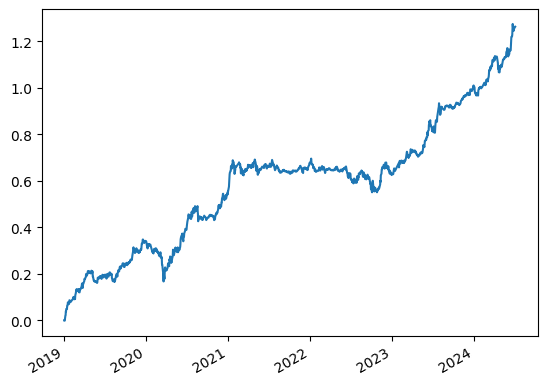

In [15]:
results.returns.cumsum().plot()

Start date,2019-01-02
End date,2024-07-01
Total months,63
,Backtest
Annual return,25.88%
Cumulative returns,238.174%
Annual volatility,13.002%
Sharpe ratio,1.84
Calmar ratio,1.54
Stability,0.89
Max drawdown,-16.781%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.78,2019-12-18,2020-03-19,2020-06-05,111
1,13.99,2022-01-05,2022-10-25,2023-03-06,279
2,6.88,2024-04-02,2024-04-22,2024-05-22,34
3,6.45,2021-01-21,2021-03-10,2021-04-29,61
4,6.42,2021-04-29,2021-05-12,2022-01-05,174


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.09%,-3.54%,3.39%


Top 10 long positions of all time,max
sid,
2382,24.57%
2454,16.66%
2330,15.99%
2317,15.92%
2308,15.89%
4904,13.95%
3008,13.84%
3711,12.97%
3045,11.80%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2382,24.57%
2454,16.66%
2330,15.99%
2317,15.92%
2308,15.89%
4904,13.95%
3008,13.84%
3711,12.97%
3045,11.80%


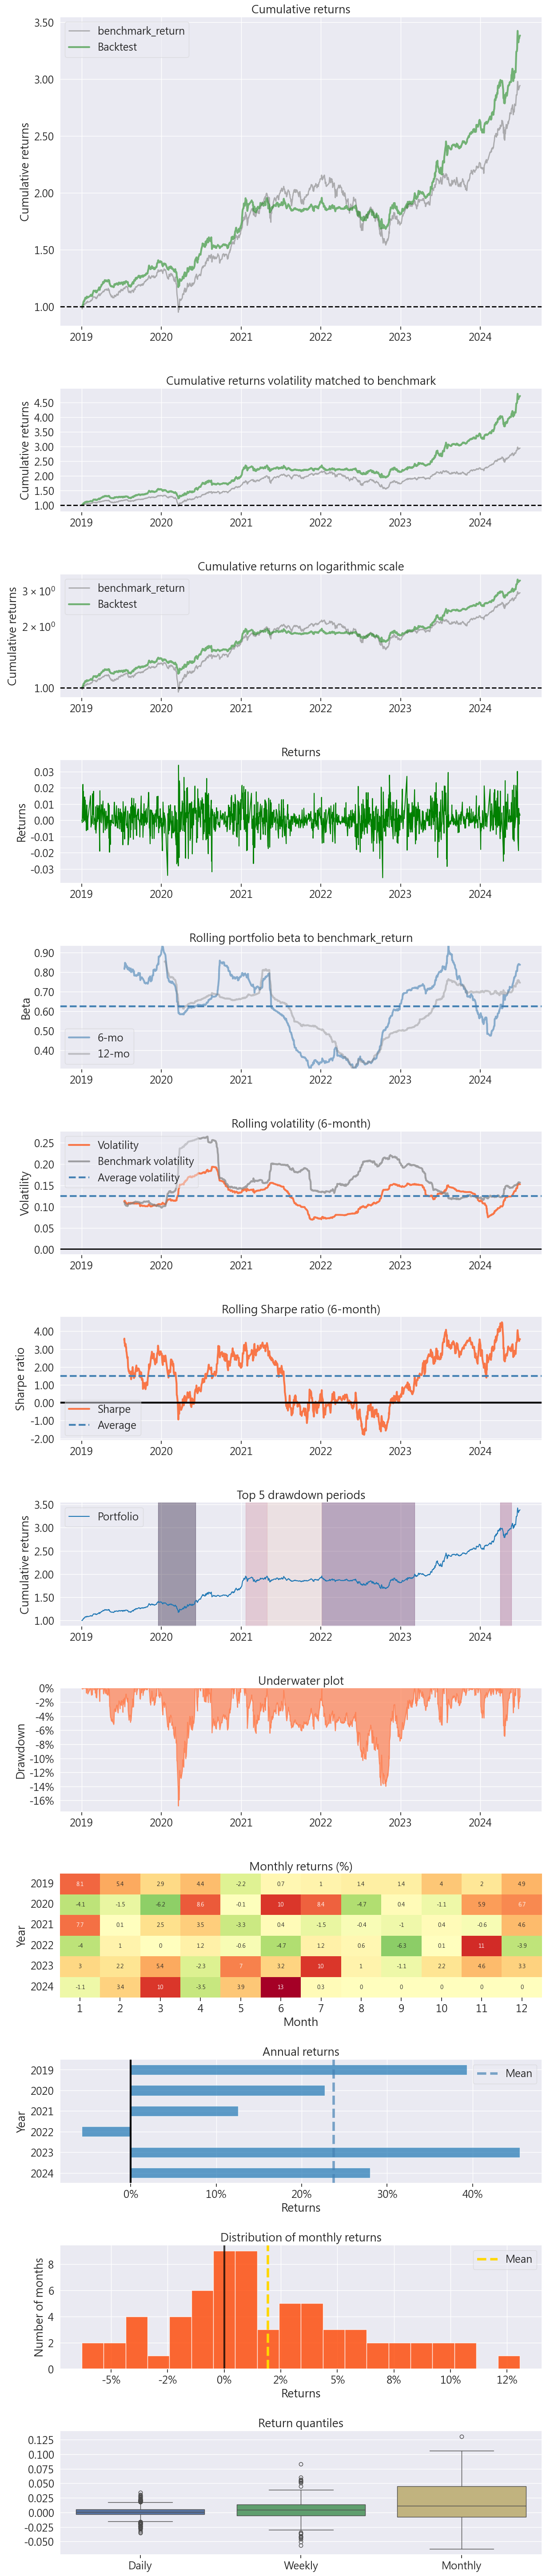

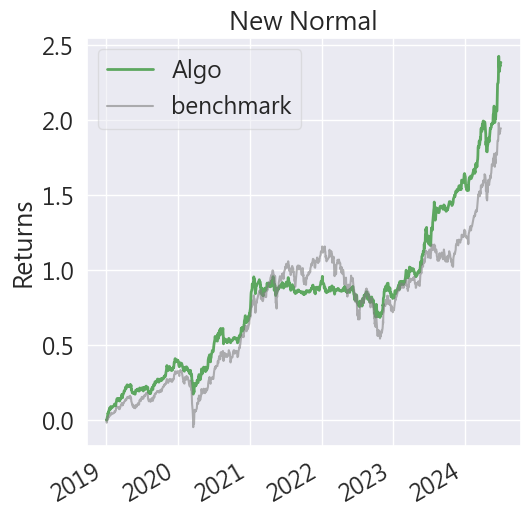

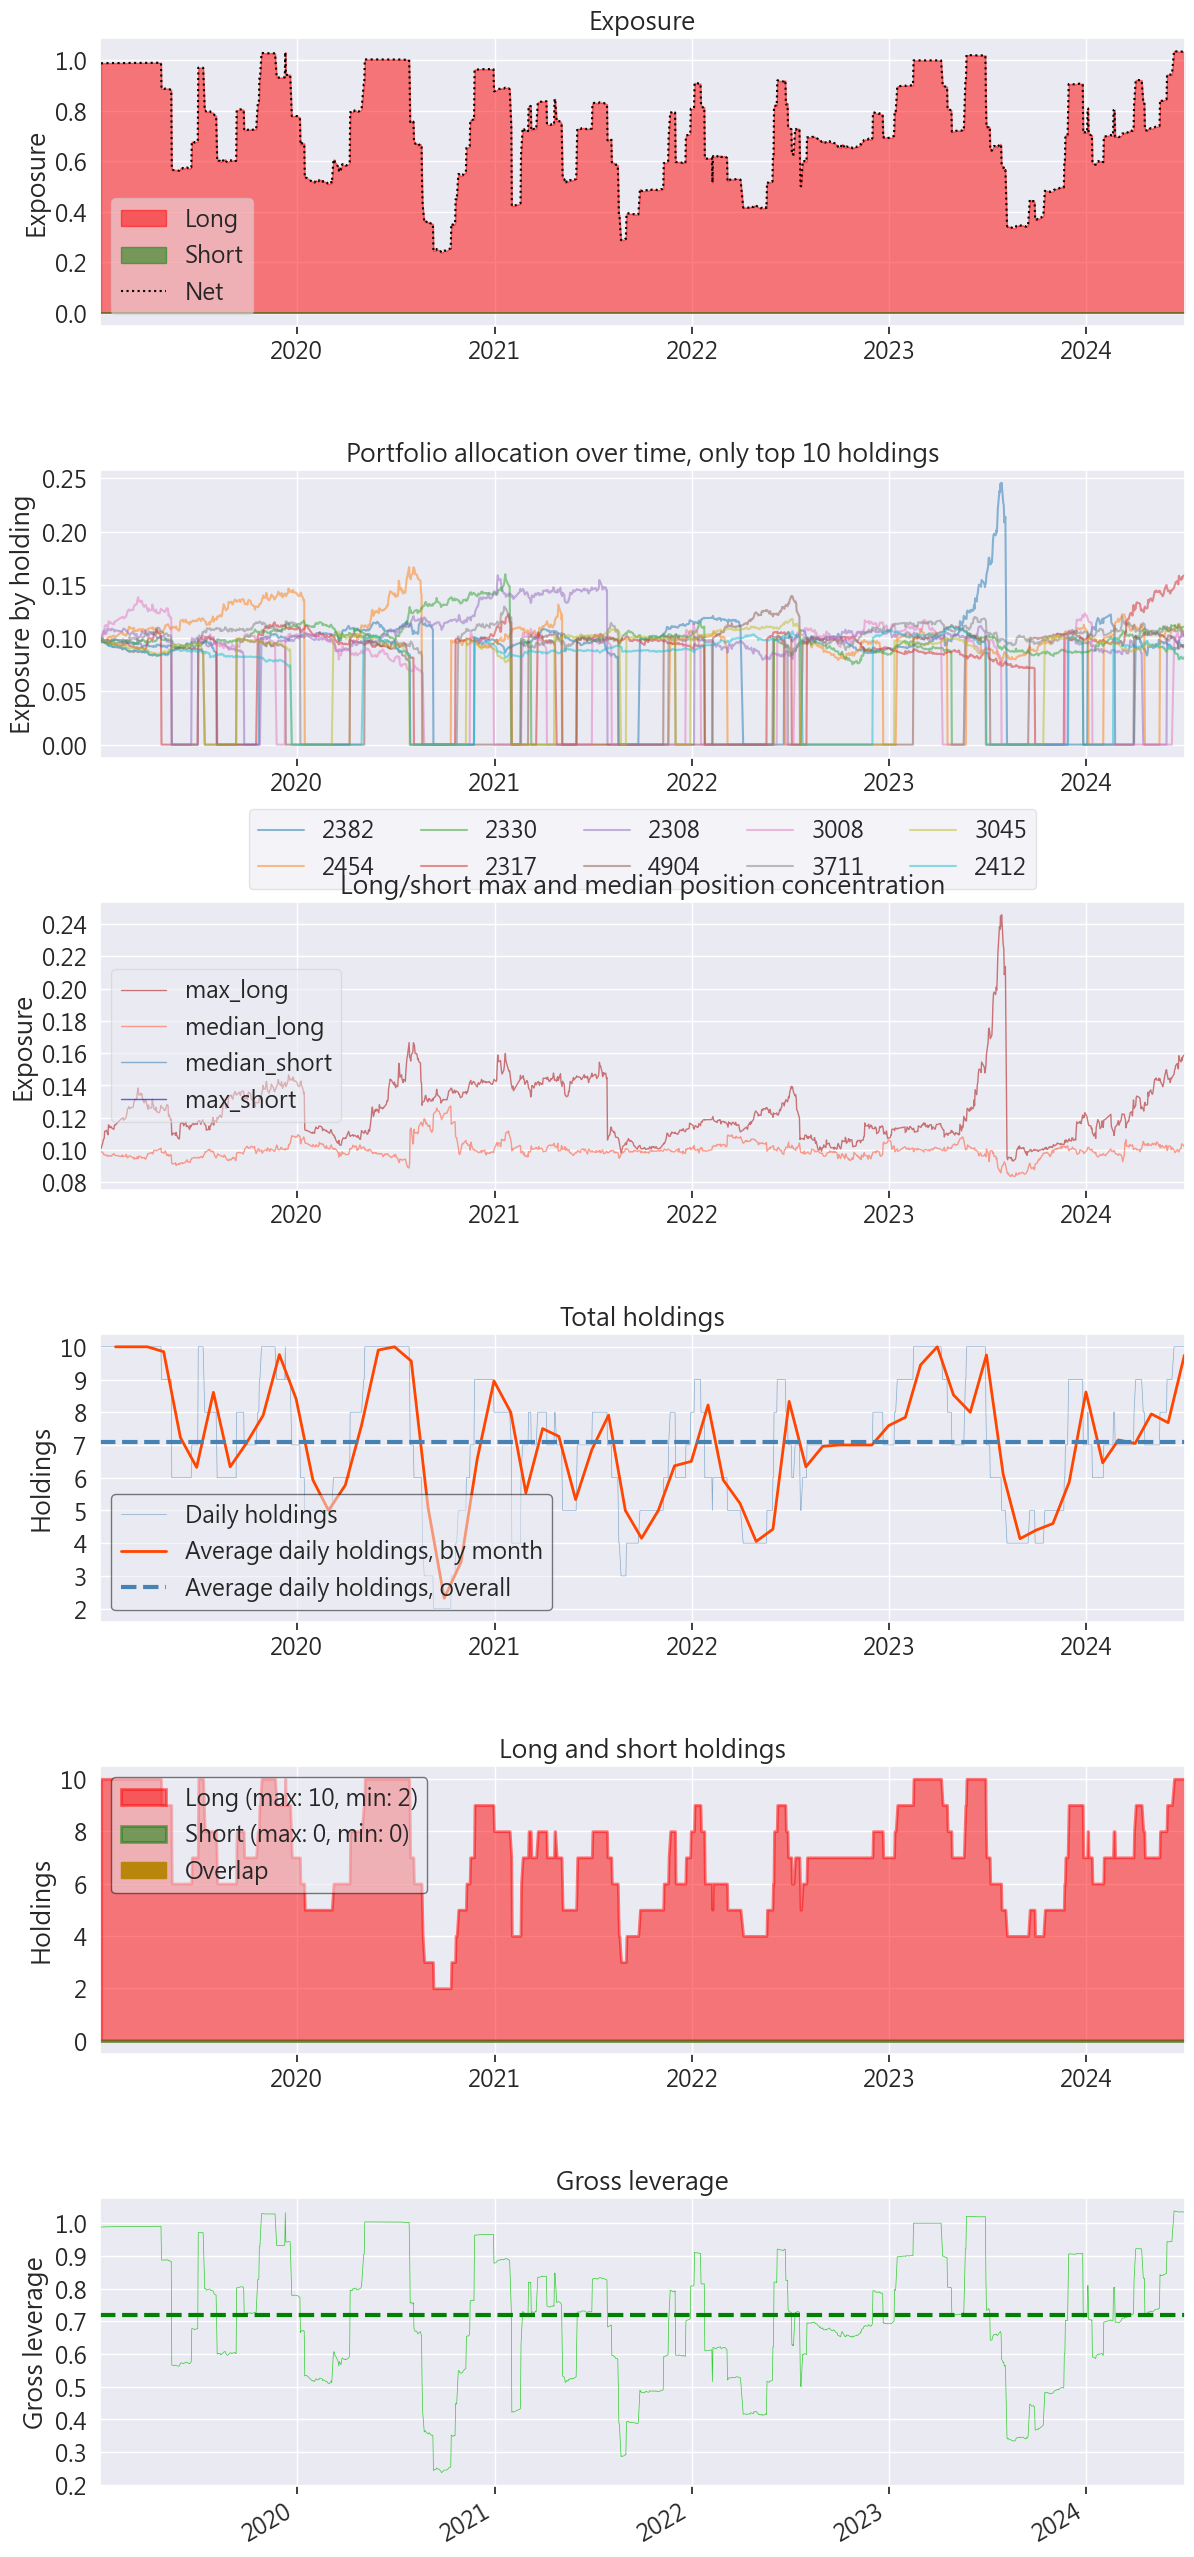

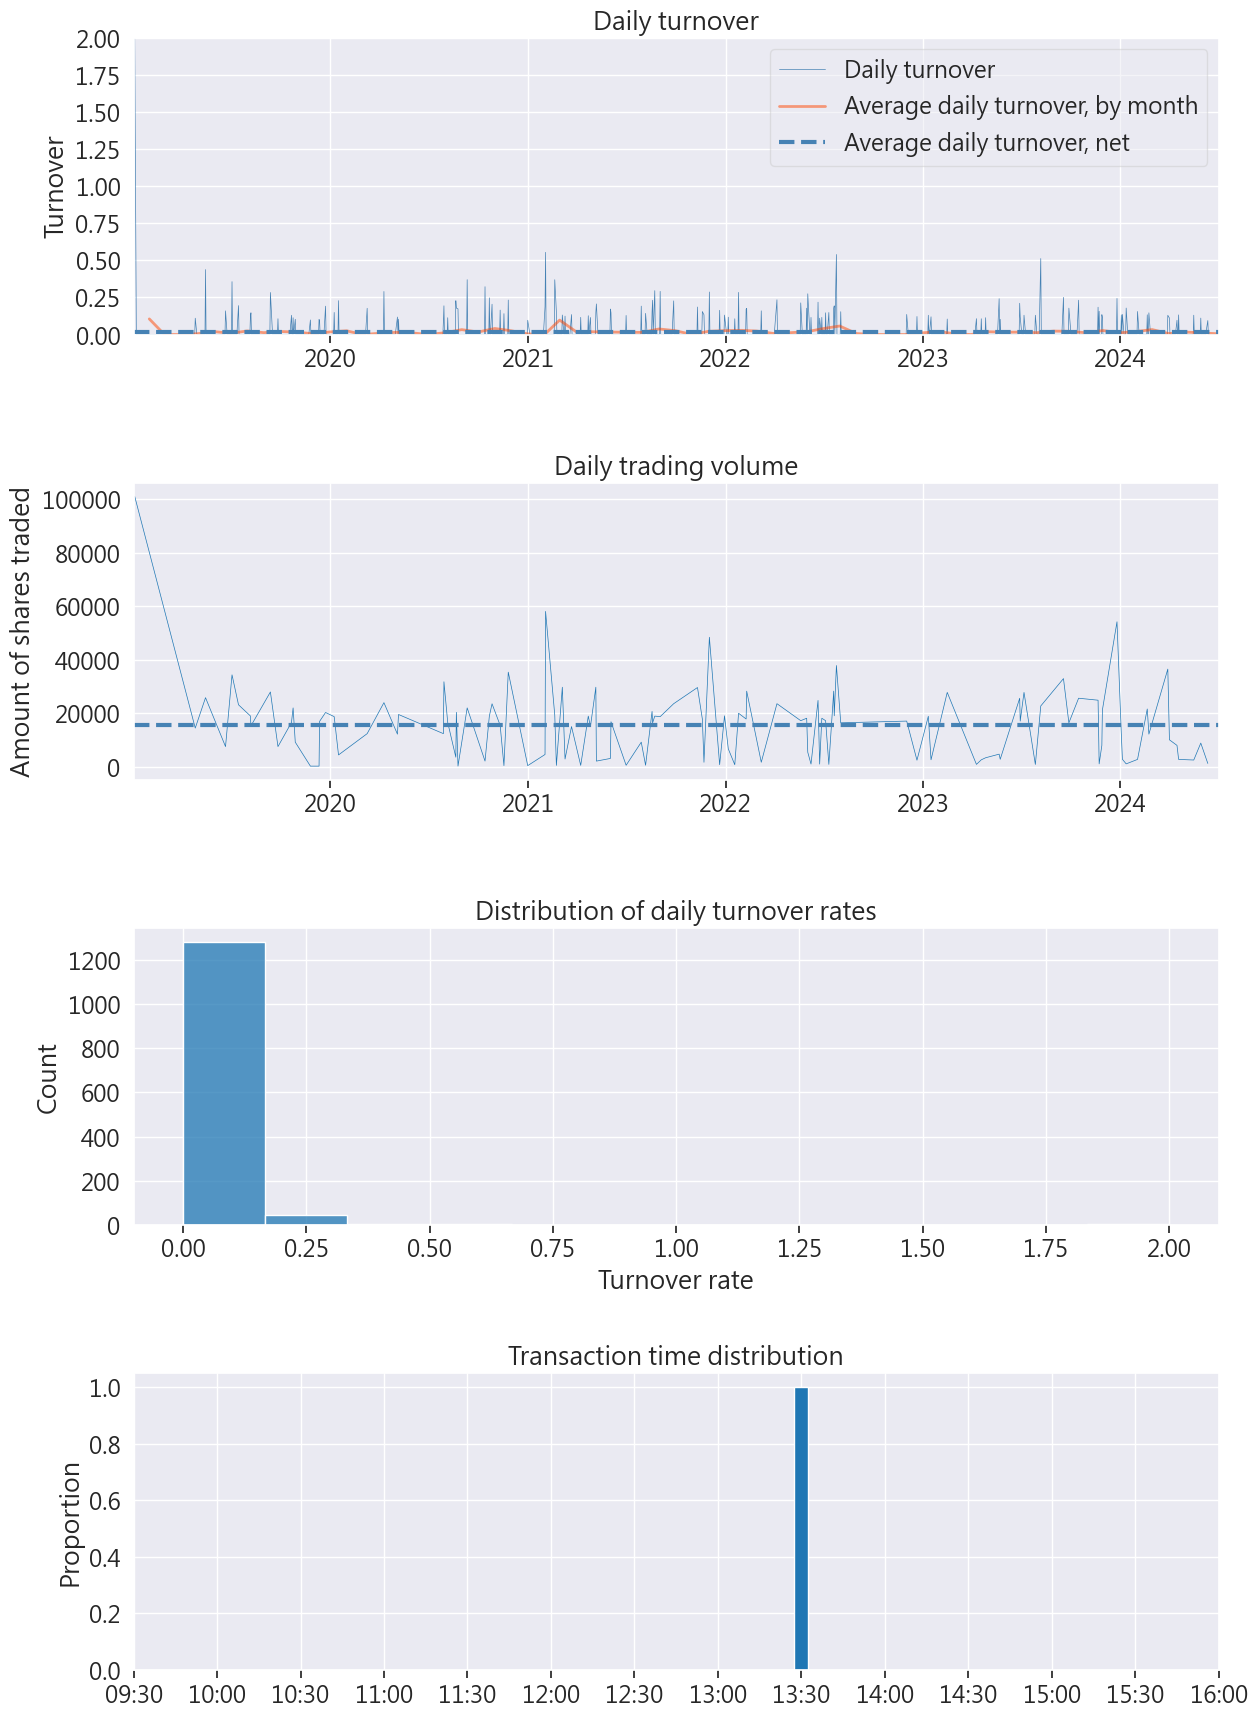

In [16]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns=returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark_rets
                         )

In [17]:
def graph(coid, backtested):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    equity = bundle.asset_finder.lookup_symbol(f'{coid}',as_of_date = None)

    dates = pipeline_result.index.get_level_values(0).drop_duplicates()
    curr_price = pipeline_result['close'].loc[:, equity]
    final_upperband = pipeline_result['final_upperband'].loc[:, equity]
    final_lowerband = pipeline_result['final_lowerband'].loc[:, equity]

    plt.figure(figsize=(20, 5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.plot(dates, curr_price, label='Current Price', color='black', alpha=0.8)
    plt.plot(dates, final_upperband, label='Upper Band', color='blue', alpha=0.4)
    plt.plot(dates, final_lowerband, label='Lower Band', color='orange', alpha=0.4)

    if backtested is True:
        plt.plot(results.index[results[f'buy_{coid}'] == True], results.loc[results[f'buy_{coid}'] == True , f'price_{coid}'], '^', markersize=7, color='red')
        plt.plot(results.index[results[f'sell_{coid}'] == True], results.loc[results[f'sell_{coid}'] == True, f'price_{coid}'], 'v', markersize=7, color='green')
            
    plt.legend()
    plt.title(f'SuperTrend {coid}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (NTD)')
    plt.gcf().autofmt_xdate()
    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

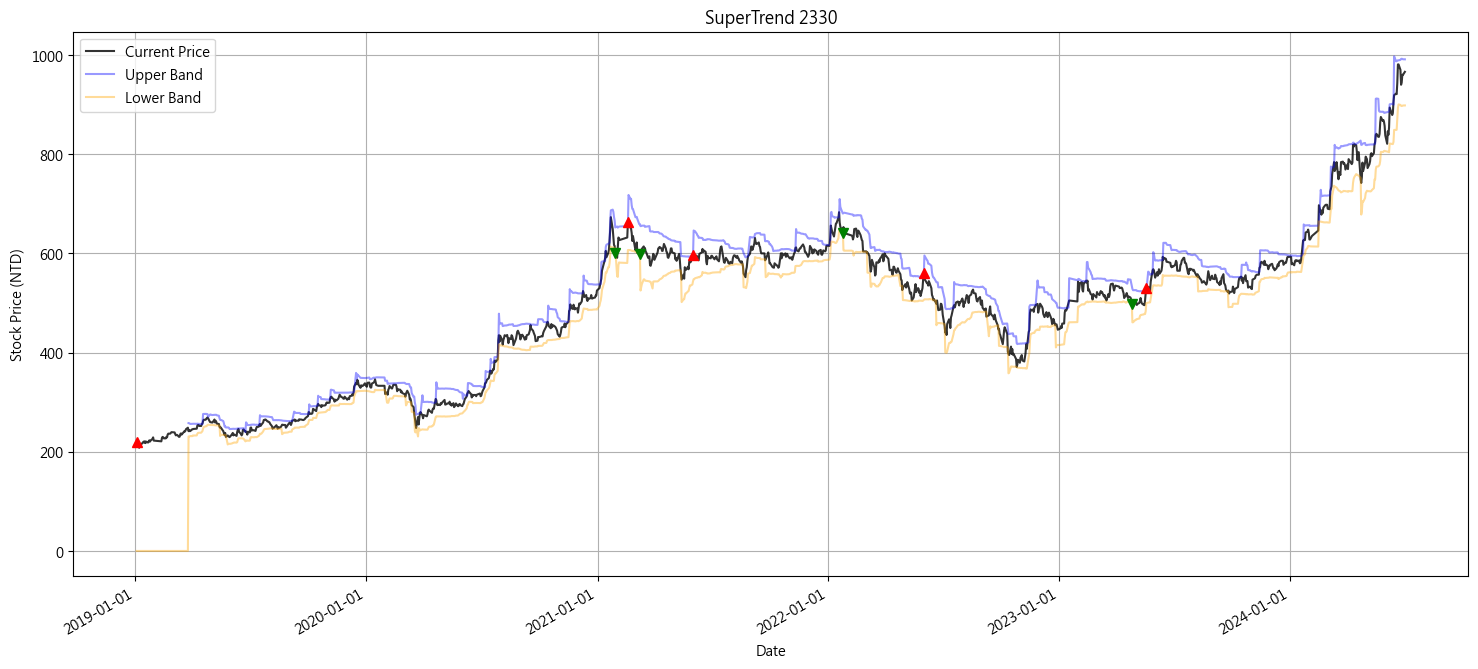

In [18]:
graph(2330, True)